# Convolutional Neural Networks in PyTorch

In this chapter we are going to implement a basic convolutional neural network in PyTorch. Going from our implementation of fully connectend neural networks to a convolutional neural network is frictionless. It is just a matter of adding some some additional modules.

First we deal with our usual overhead and import the necessary modules.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

import torchvision.transforms as T
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

We set some parameters.

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=32

And create the necessary datasets and dataloaders.

In [3]:
train_val_dataset = MNIST(root="../datasets/", train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(root="../datasets/", train=False, download=False, transform=T.ToTensor())

In [4]:
train_idxs, val_idxs = train_test_split(
                                range(len(train_val_dataset)),
                                test_size=0.1)

In [5]:
labels = train_val_dataset.targets.numpy()
indices = list(range(len(train_val_dataset)))
train_idxs, val_idxs = train_test_split(indices,
                                              test_size=0.1,
                                              stratify=labels)

In [6]:
train_dataset = Subset(train_val_dataset, train_idxs)
val_dataset = Subset(train_val_dataset, val_idxs)

In [7]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

In the module below we encounter `nn.Conv2d` and `nn.ReLU` for the first time. The convolutional module requires the number of input channels and the number of output channels. The very first channel receives MNIST with a single channel and outputs 16 feature maps. We use 2 more convolutional layers, increasing the number of channels first to 32 and eventually to 64. We keep the kernel size at 2x2 and do not use any padding. After each convolutional layer we use a ReLU activation function and a max pooling layer.

You will notice that we use two `nn.Sequential` modules. We do that to separate the calculation of the convolutional, the feature extractor, and the classification part. Before we define the module for the fully connected layers, we run a dummy tensor throuth the feature extractor in order to calculate the number of calculated features. We need that number as input into the `nn.Linear` layer. While there is a formula to calculate the number of features, we find that this automatic procedure is less prone to errors.

Finally we create the `get_features` method. We do that because we intend to draw some of the images located in the intermediary layers.

In [8]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        shape = self.conv_layers(torch.zeros(1, 1, 28, 28)).shape
        num_features = torch.prod(torch.tensor(shape)).item()
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def get_features(self, input_features, layer=0):
        with torch.inference_mode():
            x = input_features
            for i in range(layer+1):
                x = self.conv_layers[i](x)
            return x
        
    def forward(self, features):
        features = self.conv_layers(features)
        features = self.fc_layers(features)
        return features

There also `Conv1d` and `Conv3d` that deal with sequences like text or video respectively. `MaxPool1d` and `MaxPool3d` are analogous. We will encounter those modules as we move along.

The functions to track performance, plot the history of training and the to train the neural network are similar to those from the previous chapters.

In [9]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(features)
            
            predictions = logits.max(dim=1)[1]
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [10]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

In [11]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            logits = model(features)
            
            # Calculate Loss
            loss = criterion(logits, labels)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    return history            
            

In [12]:
model = Model()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

These are the best results for the MNIST dataset we have encountered so far. We gain validation accuracy around 98.5%. There is still some room for improvement, but we have already more or less solved handwritten digits classification.

In [13]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch:  1/10 | Train Loss: 0.00383 | Val Loss: 0.00423 | Train Acc: 0.962 | Val Acc: 0.957
Epoch:  2/10 | Train Loss: 0.00207 | Val Loss: 0.00245 | Train Acc: 0.980 | Val Acc: 0.975
Epoch:  3/10 | Train Loss: 0.00151 | Val Loss: 0.00193 | Train Acc: 0.985 | Val Acc: 0.979
Epoch:  4/10 | Train Loss: 0.00170 | Val Loss: 0.00211 | Train Acc: 0.983 | Val Acc: 0.979
Epoch:  5/10 | Train Loss: 0.00095 | Val Loss: 0.00156 | Train Acc: 0.990 | Val Acc: 0.985
Epoch:  6/10 | Train Loss: 0.00085 | Val Loss: 0.00165 | Train Acc: 0.991 | Val Acc: 0.984
Epoch:  7/10 | Train Loss: 0.00098 | Val Loss: 0.00200 | Train Acc: 0.989 | Val Acc: 0.981
Epoch:  8/10 | Train Loss: 0.00056 | Val Loss: 0.00139 | Train Acc: 0.995 | Val Acc: 0.986
Epoch:  9/10 | Train Loss: 0.00053 | Val Loss: 0.00150 | Train Acc: 0.995 | Val Acc: 0.985
Epoch: 10/10 | Train Loss: 0.00054 | Val Loss: 0.00181 | Train Acc: 0.994 | Val Acc: 0.984


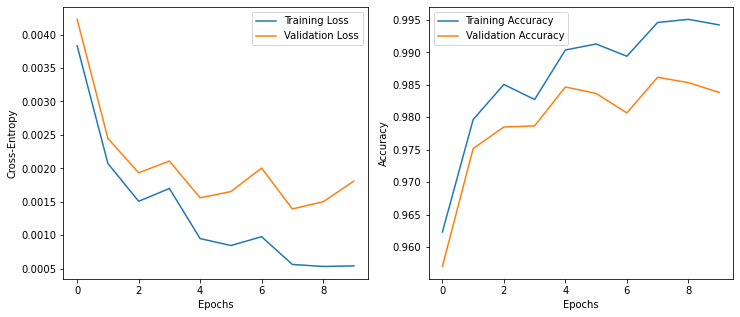

In [14]:
plot_history(history)

Below we draw 10 MNIST images and the images that are produced in the intermediary layers.

While we claimed in the theoretical part, that convolutional layers extract features that are useful for training, it becomes obvious that those features are not easy to interpret by the human eye. At the end we are left with just 4 pixels and it is hard to tell how these values are related to numbers between 0 and 9. Yet the results of the training speak for themselves. Convolutional neural networks work very well.

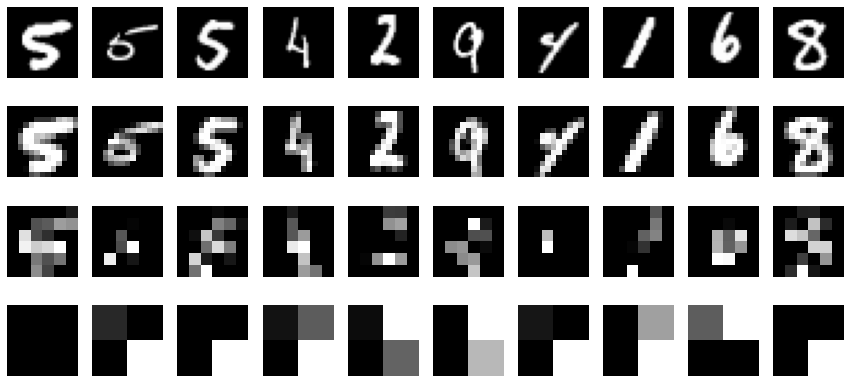

In [16]:
num_images = 10
layers = [2, 5, 8]
fig = plt.figure(figsize=(15, 7))
for i in range(num_images):
    # draw original image
    fig.add_subplot(4, num_images, i+1)
    orig_img = np.array(train_dataset[i][0]).squeeze()
    plt.imshow(orig_img, cmap="gray")
    plt.axis('off')
    
    torch_img = train_dataset[i][0].to(DEVICE)
    # draw images after convolution, relu and maxpooling
    # the index of the layer is described in the layers list
    for idx, layer in enumerate(layers):
        conv_imgs = model.get_features(torch_img, layer)
        # we only look at one channel
        conv_img = np.array(conv_imgs[5].cpu())
        fig.add_subplot(4, num_images, num_images*(idx+1)+i+1)
        plt.imshow(conv_img, cmap="gray")
        plt.axis('off')

plt.show()